In [3]:
pip install transformers datasets


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Base path to the assignment 2 folder
base_path = '/content/drive/My Drive/assignment 2'

# Path to the images folder
images_path = f"{base_path}/images"

# Path to the result.json file
result_path = f"{base_path}/result.json"


In [6]:
import os

# List files in the assignment 2 folder
print("Files in assignment 2:", os.listdir(base_path))

# List files in the images folder
print("Files in images folder:", os.listdir(images_path))



Files in assignment 2: ['result.json', 'images', 'metadata.jsonl']
Files in images folder: ['05aa5d39-cd_04.jpg', '1f84d4d9-cd_09.jpg', 'd5622538-cd_23.jpg', '1e42463b-cd_32.jpg', '8784dc2e-cd_24.jpg', '14561402-cd_35.jpg', 'a1cc5795-cd_08.jpg', 'f1b656ed-cd_10.jpg', '0b087c70-cd_07.jpg', '4fdf0704-cd_22.jpg', '399a6b67-cd_34.jpg']


In [7]:
import json

with open(result_path) as f:
    cocodata = json.load(f)

In [8]:
import os

huggingdata = []
for image in cocodata['images']:
    image['file_name'] = image['file_name'].split(os.path.sep)[-1]
    image['image_id'] = image['id']
    image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
    for annot in cocodata['annotations']:
        if annot['image_id'] == image['id']:
            image['objects']['bbox'].append(annot['bbox'])
            image['objects']['category'].append(annot['category_id'])
            image['objects']['area'].append(annot['area'])
            image['objects']['id'].append(annot['id'])
    huggingdata.append(image)


In [9]:
with open("/content/drive/My Drive/assignment 2/metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")

In [10]:
!pip install datasets


In [11]:
pip install -U albumentations opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.5/680.5 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [12]:
MODEL_NAME = "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"
IMAGE_SIZE = 480

In [13]:
from datasets import load_dataset

# Load the candy dataset from the specified folder
candy_data = load_dataset("imagefolder", data_dir="/content/drive/My Drive/assignment 2")

# Check if the validation split exists, if not, create a train-validation split
if "validation" not in candy_data :
    split = candy_data["train"].train_test_split(test_size=0.15, seed=1337)
    candy_data["train"] = split["train"]
    candy_data["validation"] = split["test"]

# Print the dataset structure to verify
print(candy_data)


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 2
    })
})


In [14]:
candy_data = candy_data.cast_column("image", candy_data["train"].features["image"])  # ensure image is PIL Image format
candy_data = candy_data.map(lambda example: {
    "image_id": example.get("image_id", None),  # adjust with actual ID extraction
    "image": example["image"],
    "width": example.get("width", example["image"].size[0]),  # assuming width from image if not in metadata
    "height": example.get("height", example["image"].size[1]),  # assuming height from image if not in metadata
    "objects": example.get("objects", None)  # adjust if object data is present in metadata
})

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [15]:
print(candy_data)

DatasetDict({
    train: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 2
    })
})


In [16]:
candy_data["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x225>,
 'width': 300,
 'height': 225,
 'id': 8,
 'image_id': 8,
 'objects': {'bbox': [[62.84916201117308,
    155.44692737430157,
    43.57541899441343,
    25.139664804469216],
   [177.23463687150846,
    0.41899441340782123,
    39.385474860335165,
    36.03351955307261],
   [174.30167597765347,
    180.58659217877081,
    57.402234636871654,
    37.709497206703915],
   [113.96648044692736,
    145.8100558659218,
    35.61452513966483,
    50.27932960893843],
   [56.98324022346362,
    55.72625698324006,
    33.51955307262576,
    29.329608938547498],
   [186.03351955307258,
    85.89385474860336,
    27.234636871508382,
    25.558659217877135],
   [152.93296089385476,
    158.79888268156424,
    25.977653631285,
    28.91061452513964],
   [175.97765363128497,
    111.87150837988825,
    25.558659217877103,
    27.65363128491619],
   [160.0558659217877,
    39.804469273742974,
    25.977653631284902,
    27.65363128491

In [17]:
import numpy as np
import os
from PIL import Image, ImageDraw

In [18]:
from PIL import ImageDraw

# Select an example image and its annotations
image = candy_data["train"][0]["image"]
annotations = candy_data["train"][0]["objects"]

draw = ImageDraw.Draw(image)

categories = candy_data["train"].features["objects"]["category"]


id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")




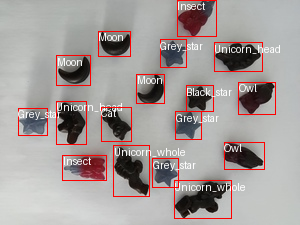

In [19]:
image

In [20]:
from transformers import AutoImageProcessor

In [21]:
MAX_SIZE = IMAGE_SIZE

In [22]:
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [23]:
import albumentations as A

In [24]:
train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

In [25]:
validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [26]:
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }


In [27]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [28]:
from functools import partial

# Make transform functions for each dataset split
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)

# Apply the transformations to the dataset splits
candy_data["train"] = candy_data["train"].with_transform(train_transform_batch)
candy_data["validation"] = candy_data["validation"].with_transform(validation_transform_batch)

# Example usage: Retrieve and print the 9th item in the transformed training data
print(candy_data["train"][1])


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[0.4679, 0.4679, 0.4851,  ..., 0.3138, 0.3138, 0.3138],
         [0.4679, 0.4679, 0.4851,  ..., 0.3138, 0.3138, 0.3138],
         [0.4679, 0.4679, 0.4851,  ..., 0.3309, 0.3309, 0.3309],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6254, 0.6254, 0.6429,  ..., 0.4678, 0.4678, 0.4678],
         [0.6254, 0.6254, 0.6429,  ..., 0.4678, 0.4678, 0.4678],
         [0.6254, 0.6429, 0.6604,  ..., 0.4853, 0.4853, 0.4853],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8448, 0.8448, 0.8448,  ..., 0.6182, 0.6182, 0.6182],
         [0.8448, 0.8448, 0.8448,  ..., 0.6182, 0.6182, 0.6182],
         [0.8448, 0.8448, 0.8622,  ..., 0

In [29]:
import torch

def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data


In [30]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [31]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 27.0 MB/s eta 0:00:00


In [32]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [33]:
@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

In [34]:


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [35]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([8]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="candy_data",
    num_train_epochs=300,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=True,
)

In [37]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=candy_data["train"],
    eval_dataset=candy_data["validation"],
    #processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Black Star,Mar 100 Black Star,Map Cat,Mar 100 Cat,Map Grey Star,Mar 100 Grey Star,Map Insect,Mar 100 Insect,Map Moon,Mar 100 Moon,Map Owl,Mar 100 Owl,Map Unicorn Head,Mar 100 Unicorn Head,Map Unicorn Whole,Mar 100 Unicorn Whole
1,No log,1.227403,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,No log,1.246465,0.018600,0.031600,0.009400,0.027600,0.000000,-1.000000,0.000000,0.133300,0.300000,0.433300,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.022400,0.400000,0.033300,0.500000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,No log,1.194300,0.036800,0.048600,0.048600,0.032800,0.266700,-1.000000,0.000000,0.133300,0.500000,0.500000,0.800000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.066700,0.800000,0.043700,0.700000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,No log,1.197163,0.024100,0.034500,0.034500,0.031700,0.000000,-1.000000,0.000000,0.116700,0.350000,0.466700,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.018600,0.350000,0.053800,0.700000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,No log,1.182124,0.021300,0.027600,0.027600,0.026800,0.000000,-1.000000,0.000000,0.116700,0.383300,0.500000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.016800,0.350000,0.047100,0.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,No log,1.126871,0.019500,0.027900,0.027900,0.029200,0.000000,-1.000000,0.000000,0.000000,0.350000,0.500000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.025200,0.450000,0.033300,0.600000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7,No log,1.122939,0.016000,0.026900,0.008400,0.023700,0.000000,-1.000000,0.000000,0.000000,0.300000,0.433300,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.020200,0.400000,0.027800,0.500000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
8,No log,1.082876,0.037600,0.051400,0.051400,0.027800,0.450000,-1.000000,0.000000,0.266700,0.500000,0.466700,0.900000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.071500,0.800000,0.041200,0.700000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,No log,1.124261,0.037700,0.047500,0.047500,0.030400,0.400000,-1.000000,0.000000,0.116700,0.550000,0.533300,0.800000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.063100,0.750000,0.050000,0.900000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
10,No log,1.169757,0.035200,0.046300,0.046300,0.028300,0.266700,-1.000000,0.000000,0.133300,0.500000,0.500000,0.800000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.066700,0.800000,0.038900,0.700000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

TrainOutput(global_step=600, training_loss=0.5588567161560059, metrics={'train_runtime': 1923.8282, 'train_samples_per_second': 1.403, 'train_steps_per_second': 0.312, 'total_flos': 4.850761241088e+17, 'train_loss': 0.5588567161560059, 'epoch': 300.0})

In [44]:
model.save_pretrained("/content/candy_detector_model")



In [46]:
from huggingface_hub import notebook_login

notebook_login()

In [49]:
trainer.push_to_hub("candy_detector")

CommitInfo(commit_url='https://huggingface.co/alekhyavinni12/detr_finetuned_cppe5/commit/0322bbf61ef32ac38569014b7be4dda1f87eb263', commit_message='candy_detector', commit_description='', oid='0322bbf61ef32ac38569014b7be4dda1f87eb263', pr_url=None, pr_revision=None, pr_num=None)

In [70]:
def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # Ensure image_size is a tuple with two values
    if isinstance(image_size, torch.Tensor) and image_size.dim() == 1:
        image_size = (image_size[0].item(), image_size[1].item())

    if not isinstance(image_size, tuple) or len(image_size) != 2:
        raise ValueError("image_size must be a tuple of (height, width)")

    height, width = image_size

    # Convert center to corners format
    boxes = center_to_corners_format(boxes)

    # Convert to absolute coordinates
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes


In [57]:
import torch
import requests

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

image_path = "/content/drive/My Drive/assignment 2/images/0b087c70-cd_07.jpg"
image = Image.open(image_path)

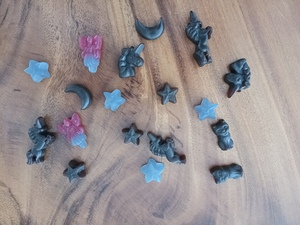

In [58]:
image

In [59]:
from transformers import pipeline

def candy_counter(image):
    # Make sure model path points to the saved model directory
    obj_detector = pipeline("object-detection", model="/content/candy_detector_model")
    detections = obj_detector(image, threshold=0.2)  # Adjust threshold if needed

    # Initialize counts for each candy type
    candy_counts = {'Moon': 0, 'Insect': 0, 'Black_star': 0, 'Grey_star': 0,
                    'Unicorn_whole': 0, 'Unicorn_head': 0, 'Owl': 0, 'Cat': 0}

    # Count the detected candies by type
    for detection in detections:
        label = detection['label']
        if label in candy_counts:
            candy_counts[label] += 1

    return candy_counts

In [60]:
# Evaluate and calculate mAP on the validation dataset
metrics_vali = trainer.evaluate(eval_dataset=candy_data["validation"], metric_key_prefix="eval")

# Print out mAP score specifically
print("mAP Score:", metrics_vali.get("eval_map", "mAP not available"))
print("Detailed Evaluation Metrics:")
pprint(metrics_vali)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


mAP Score: 0.3056
Detailed Evaluation Metrics:
{'epoch': 300.0,
 'eval_loss': 0.7070087194442749,
 'eval_map': 0.3056,
 'eval_map_50': 0.3333,
 'eval_map_75': 0.3333,
 'eval_map_Black_star': -1.0,
 'eval_map_Cat': 0.5,
 'eval_map_Grey_star': -1.0,
 'eval_map_Insect': 0.4168,
 'eval_map_Moon': 0.0,
 'eval_map_Owl': -1.0,
 'eval_map_Unicorn_head': -1.0,
 'eval_map_Unicorn_whole': -1.0,
 'eval_map_large': -1.0,
 'eval_map_medium': 0.3,
 'eval_map_small': 0.4333,
 'eval_mar_1': 0.4833,
 'eval_mar_10': 0.6167,
 'eval_mar_100': 0.6167,
 'eval_mar_100_Black_star': -1.0,
 'eval_mar_100_Cat': 1.0,
 'eval_mar_100_Grey_star': -1.0,
 'eval_mar_100_Insect': 0.85,
 'eval_mar_100_Moon': 0.0,
 'eval_mar_100_Owl': -1.0,
 'eval_mar_100_Unicorn_head': -1.0,
 'eval_mar_100_Unicorn_whole': -1.0,
 'eval_mar_large': -1.0,
 'eval_mar_medium': 0.9,
 'eval_mar_small': 0.6,
 'eval_runtime': 0.9103,
 'eval_samples_per_second': 2.197,
 'eval_steps_per_second': 1.099}


In [ ]:
# Detect bounding boxes

with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [61]:
# Since i am using Windows Devices. Checking the available device and assigning device CUDA (for systems with NVIDIA GPUs), or CPU as a fallback.

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
# Detect bounding boxes

with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Unicorn_whole with confidence 0.623 at location [183.34, 14.04, 212.78, 58.81]
Detected Unicorn_whole with confidence 0.615 at location [25.65, 109.4, 54.95, 150.83]
Detected Insect with confidence 0.542 at location [54.34, 106.32, 91.71, 134.72]
Detected Unicorn_head with confidence 0.527 at location [222.51, 54.41, 252.07, 89.97]
Detected Unicorn_whole with confidence 0.52 at location [147.48, 122.44, 186.69, 151.56]
Detected Insect with confidence 0.516 at location [75.78, 33.96, 104.19, 64.6]
Detected Grey_star with confidence 0.515 at location [139.67, 148.23, 163.07, 168.86]
Detected Grey_star with confidence 0.506 at location [192.9, 91.78, 217.49, 109.0]
Detected Moon with confidence 0.493 at location [63.61, 79.88, 91.97, 99.56]
Detected Grey_star with confidence 0.493 at location [61.56, 150.88, 86.25, 169.09]
Detected Grey_star with confidence 0.478 at location [102.05, 84.57, 124.06, 101.48]
Detected Moon with confidence 0.466 at location [135.04, 18.32, 165.17, 36

In [63]:
from transformers import pipeline

def candy_counter(image):
    # Make sure model path points to the saved model directory
    obj_detector = pipeline("object-detection", model="/content/candy_detector_model")
    detections = obj_detector(image, threshold=0.2)  # Adjust threshold if needed

    # Initialize counts for each candy type
    candy_counts = {'Moon': 0,
                    'Insect': 0,
                    'Black_star': 0,
                    'Grey_star': 0,
                    'Unicorn_whole': 0,
                    'Unicorn_head': 0,
                    'Owl': 0,
                    'Cat': 0
    }

    # Count the detected candies by type
    for detection in detections:
        label = detection['label']
        if label in candy_counts:
            candy_counts[label] += 1

    return candy_counts

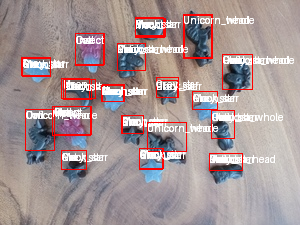

In [74]:
# Let’s plot the result

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image